# Building Makemore MLP 2 Exercise

## Imports

In [ ]:
from tqdm import tqdm
import numpy
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plot
import random
import math

In [ ]:
g = torch.Generator().manual_seed(42)

## Setup

In [ ]:
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [ ]:
len(words)

32033

In [ ]:
def generate_training_set(words, block_size, print_disabled=False):
    
    chars = sorted(list(set(''.join(words))))
    stoi = {s: i+1 for i, s in enumerate(chars)}
    stoi['.'] = 0
    itos = {i:s for s, i in stoi.items()}
    
    X, Y = [], []
    
    for w in words:
        if print_disabled: print(w)
        
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            if print_disabled: print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [ ]:
X, Y = generate_training_set(words, 3)

In [ ]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
def generate_train_valid_test_split(words, block_size=3):
    random.seed(42)
    random.shuffle(words)
    n1 = int(0.8*len(words))
    n2 = int(0.9*len(words))

    Xtr, Ytr = generate_training_set(words[:n1], block_size)
    Xdev, Ydev = generate_training_set(words[n1:n2], block_size)
    Xte, Yte = generate_training_set(words[n2:], block_size)
    
    return Xtr, Ytr, Xdev, Ydev, Xte, Yte

In [ ]:
Xtr, Ytr, Xdev, Ydev, Xte, Yte = generate_train_valid_test_split(words, block_size=3)

In [ ]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [ ]:
Xdev.shape, Ydev.shape

(torch.Size([22655, 3]), torch.Size([22655]))

In [ ]:
Xte.shape, Yte.shape

(torch.Size([22866, 3]), torch.Size([22866]))

## E01
>  I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 
> 1) the network trains just fine or 
> 2) the network doesn't train at all, but actually it is 
> 3) the network trains but only partially, and achieves a pretty bad final performance. 

> Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

In [ ]:
def train(X, Y, epochs, bs = 32, context_length = 3, vocab_size = 27, embedding_size = 10, n_hidden = 100, print_at_every_epoch=10):
    
    C = torch.randn((vocab_size, embedding_size), generator=g)
    
    layers = [
        nn.Linear(context_length * embedding_size, n_hidden), nn.BatchNorm1d(n_hidden), nn.Tanh(),
        nn.Linear(n_hidden, n_hidden), nn.BatchNorm1d(n_hidden), nn.Tanh(),
        nn.Linear(n_hidden, n_hidden), nn.BatchNorm1d(n_hidden), nn.Tanh(),
        nn.Linear(n_hidden, n_hidden), nn.BatchNorm1d(n_hidden), nn.Tanh(),
        nn.Linear(n_hidden, n_hidden), nn.BatchNorm1d(n_hidden), nn.Tanh(),
        nn.Linear(n_hidden, vocab_size), nn.BatchNorm1d(vocab_size)
    ]
    visualisation = [-1] * len(layers) 

    def get_activation(layer_num):
        def hook_fn(m, i, o): visualisation[layer_num] = o 
        return hook_fn
        
    for i, layer in enumerate(layers):
        layer.register_forward_hook(get_activation(i))
        if isinstance(layer, nn.Linear):
            nn.init.zeros_(layer.weight)
            nn.init.zeros_(layer.bias)

    print('Total number of layers are : ', len(layers))
    parameters = [C] + [p for layer in layers for p in layer.parameters()]
    print('Total number of parameters are :', sum(p.nelement() for p in parameters))

    
    # set parameters to required grad
    for p in parameters:
        p.requires_grad = True

    
        
    lossi = []
    ud = []
    for i in range(epochs):
        ix = torch.randint(0, len(X), (bs,),  generator=g)
        
        Xb, Yb = X[ix], Y[ix]
        
        emb = C[Xb]
        x = emb.view(emb.shape[0], -1)
        
        for layer in layers:
            x = layer(x)
            x.retain_grad()


        loss = F.cross_entropy(x, Yb)
        
#         for layer in layers:
#             layer.retain_grad()
            
        for p in parameters:
            p.retain_grad()
            p.grad = None
            
        loss.backward()
        
        
        
        
        lr = 0.1 if i <= 100_000 else 0.01 # lr decay
        
        for p in parameters:
            p.data += -lr * p.grad
        
        if print_at_every_epoch: 
            if i % print_at_every_epoch == 0:
                print(f'Epoch {i} Loss {loss.item()}')
        
        lossi.append(loss.item())
        
        with torch.no_grad():
            for p in parameters:
                grad_update_data_ratio = (lr * p.grad.std() / p.data.std()).log10().item() 
                ud.append(grad_update_data_ratio)
        
    return C, layers, lossi, ud, visualisation

In [ ]:
C, layers, losses, uds, v = train(Xtr, Ytr, 1000, print_at_every_epoch=100)

Total number of layers are :  17
Total number of parameters are : 47551
Epoch 0 Loss 3.295837163925171
Epoch 100 Loss 3.115647554397583
Epoch 200 Loss 2.883199453353882
Epoch 300 Loss 2.8183982372283936
Epoch 400 Loss 2.7845687866210938
Epoch 500 Loss 2.8769757747650146
Epoch 600 Loss 2.75632905960083
Epoch 700 Loss 2.5977225303649902
Epoch 800 Loss 2.8465943336486816
Epoch 900 Loss 3.226971387863159


In [ ]:
v[15]

tensor([[2.7777e-05, 3.3950e-05, 2.4400e-05, 1.9855e-05, 3.2619e-05, 7.8713e-06,
         2.9720e-06, 1.8255e-05, 3.6090e-05, 1.3658e-05, 2.3523e-05, 3.3139e-05,
         2.4819e-05, 3.1158e-05, 9.9366e-07, 3.1144e-05, 1.0995e-05, 3.5033e-06,
         7.2170e-06, 2.8630e-05, 2.9825e-05, 2.5997e-05, 1.2910e-05, 7.2101e-06,
         3.9578e-06, 2.8727e-05, 1.7435e-05],
        [2.7777e-05, 3.3950e-05, 2.4400e-05, 1.9855e-05, 3.2619e-05, 7.8713e-06,
         2.9720e-06, 1.8255e-05, 3.6090e-05, 1.3658e-05, 2.3523e-05, 3.3139e-05,
         2.4819e-05, 3.1158e-05, 9.9366e-07, 3.1144e-05, 1.0995e-05, 3.5033e-06,
         7.2170e-06, 2.8630e-05, 2.9825e-05, 2.5997e-05, 1.2910e-05, 7.2101e-06,
         3.9578e-06, 2.8727e-05, 1.7435e-05],
        [2.7777e-05, 3.3950e-05, 2.4400e-05, 1.9855e-05, 3.2619e-05, 7.8713e-06,
         2.9720e-06, 1.8255e-05, 3.6090e-05, 1.3658e-05, 2.3523e-05, 3.3139e-05,
         2.4819e-05, 3.1158e-05, 9.9366e-07, 3.1144e-05, 1.0995e-05, 3.5033e-06,
         7.2170e-

In [ ]:
v[-3].grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
v['Tanh()'].grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
list(layers[2].parameters())

[]

In [ ]:
@torch.no_grad()
def evaluate_loss(model, embedding, X, Y):
    emb = embedding[X]
    logits = emb.view(emb.shape[0], -1)
    for layer in model: logits = layer(logits) 
    return F.cross_entropy(logits, Y)

In [ ]:
evaluate_loss(layers,C, Xtr, Ytr), evaluate_loss(layers,C, Xdev, Ydev)

(tensor(2.8227), tensor(2.8212))

In [ ]:
emb = C[Xdev]
logits = emb.view(emb.shape[0], -1)

The loss is not good. The network does not train at except the last layers

### Lets see the activations and gradients

In [ ]:
def visualize_histograms(layers, C, Xdev):
    plot.figure(figsize=(20, 4))
    legends = []
    emb = C[Xdev]
    logits = emb.view(emb.shape[0], -1)
    for i, layer in enumerate(layers[:-1]):
        if isinstance(layer, nn.Tanh):
            t = v[i]
            print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
            hy, hx = torch.histogram(t, density=True)
            plot.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')
    plot.legend(legends)
    plot.title('gradient distribution')

layer 2 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 8 (      Tanh): mean +0.000000, std 0.000000e+00
layer 11 (      Tanh): mean +0.000000, std 0.000000e+00
layer 14 (      Tanh): mean +0.000000, std 0.000000e+00


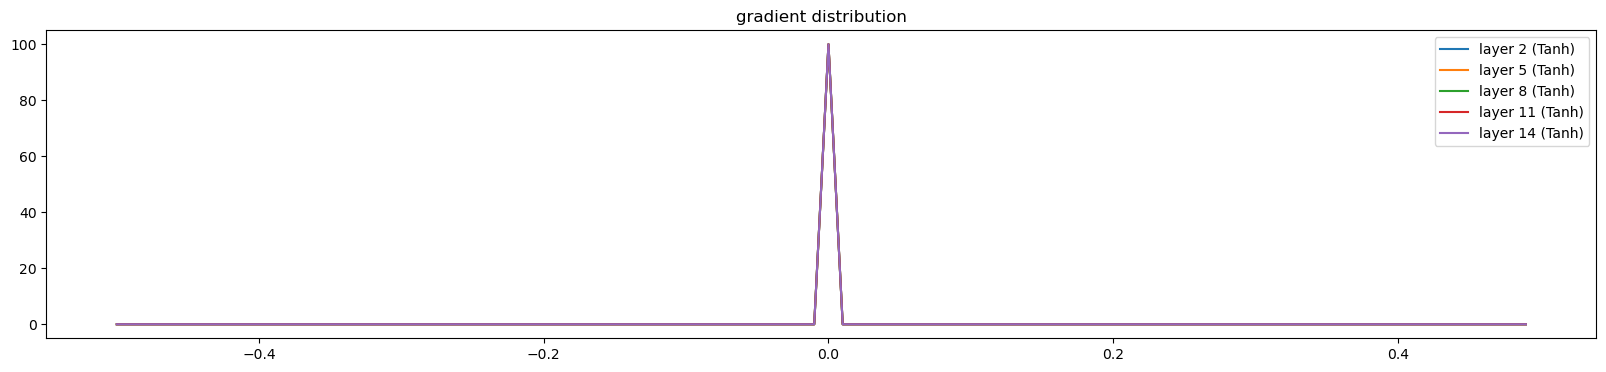

In [ ]:
visualize_histograms(layers, C, Xdev)

In [ ]:
layers[2](C[Xdev]).grad

/Users/anubhavmaity/micromamba/envs/zhnn/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:485.)
  """Entry point for launching an IPython kernel.


In [ ]:
def visualize_histograms(layers, C, Xdev):
    plot.figure(figsize=(20, 4))
    legends = []
    emb = C[Xdev]
    logits = emb.view(emb.shape[0], -1)
    for i, layer in enumerate(layers[:-1]):
        if isinstance(layer, nn.Tanh):
            t = layer.grad
            print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
            hy, hx = torch.histogram(t, density=True)
            plot.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')
    plot.legend(legends)
    plot.title('gradient distribution')

In [ ]:
visualize_histograms(layers, C, Xdev)

AttributeError: 'Tanh' object has no attribute 'grad'

<Figure size 2000x400 with 0 Axes>